Data shape: (1715, 201), Number of classes: 7


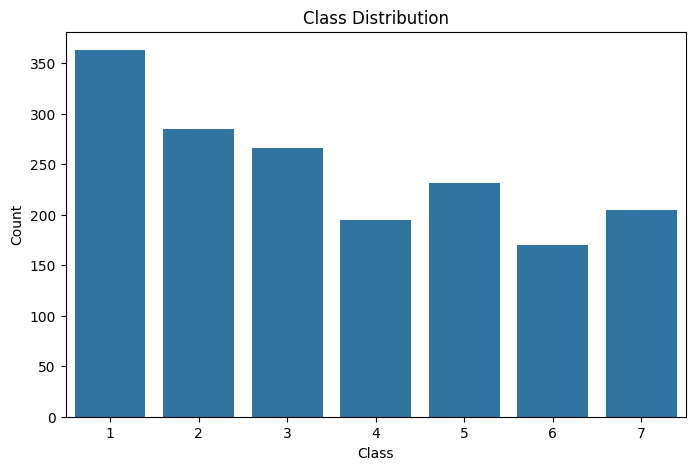

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, cohen_kappa_score, precision_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv('Cancer2025exam.csv')
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

print(f"Data shape: {X.shape}, Number of classes: {len(np.unique(y))}")

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=data.columns[0], data=data)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


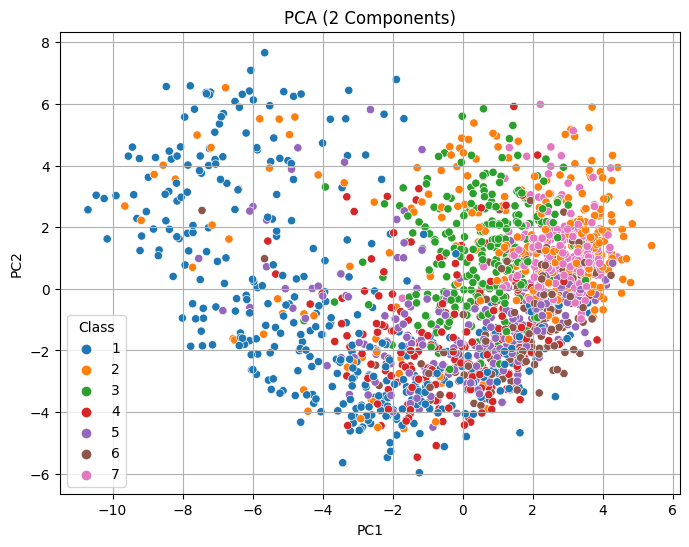

In [70]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# PCA Visualization
def plot_pca(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=125)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='tab10')
    plt.title("PCA (2 Components)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Class")
    plt.grid(True)
    plt.show()

plot_pca(X, y)


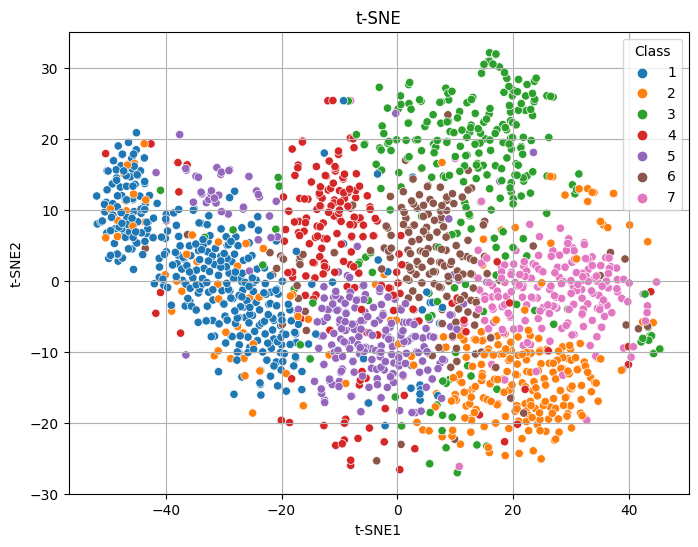

In [71]:

# t-SNE Visualization
def plot_tsne(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='tab10')
    plt.title("t-SNE")
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.legend(title="Class")
    plt.grid(True)
    plt.show()


plot_tsne(X, y)


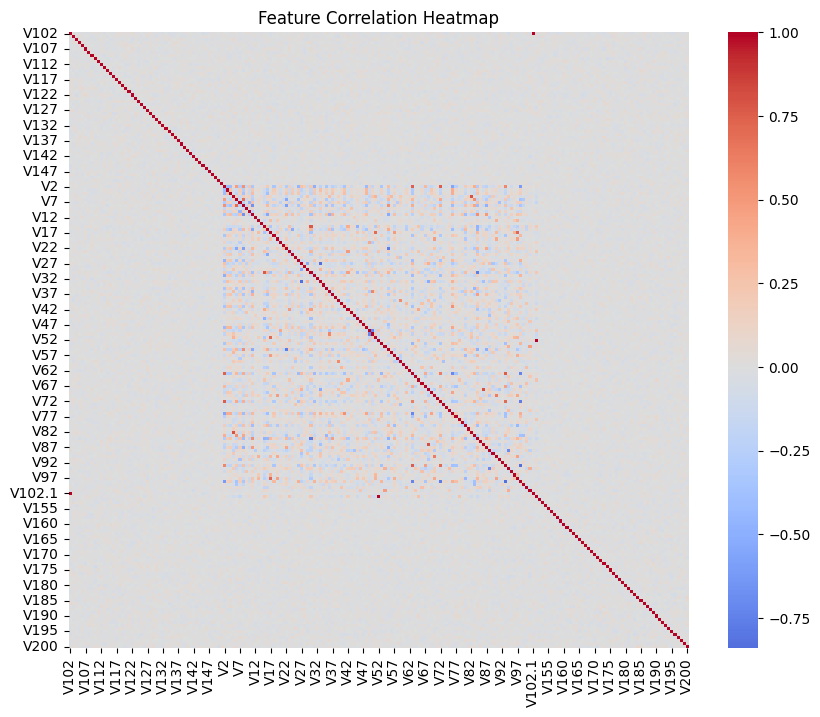

In [72]:
# Correlation heatmap
X_df = pd.DataFrame(X, columns=data.columns[1:])
plt.figure(figsize=(10, 8))
sns.heatmap(X_df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [73]:
def create_outer_splits(X, y, n_splits=5, random_state=42):
    """
    Create stratified splits for outer train-test evaluation.
    Returns list of (train_idx, test_idx) tuples.
    """
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    return list(outer_cv.split(X, y))


def get_classifiers():
    """
    Returns dictionary of classifiers to evaluate.
    """
    return {
        'Logistic Regression': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42),
        'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
        'KNN': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'Naive Bayes': GaussianNB(),
        'AdaBoost': AdaBoostClassifier(random_state=42)
    }


def get_param_grids():
    """
    Slightly expanded but still computationally feasible hyperparameter grids.
    """
    return {
        'Logistic Regression': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l2'],
            'clf__solver': ['lbfgs']
        },
        'SVM': {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['linear', 'rbf'],
            'clf__gamma': ['scale', 'auto']
        },
        'KNN': {
            'clf__n_neighbors': [3, 5, 7, 9],
            'clf__weights': ['uniform', 'distance'],
            'clf__p': [1, 2]  # Manhattan and Euclidean — can differ a lot in practice
        },
        'Random Forest': {
            'clf__n_estimators': [100, 200],  # Removed 3000 — that's overkill for most problems
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_split': [2, 5],
            'clf__min_samples_leaf': [1, 2],
            'clf__bootstrap': [True]
        },
        'Naive Bayes': {
            # Still nothing to tune
        },
        'AdaBoost': {
            'clf__n_estimators': [50, 100, 200],
            'clf__learning_rate': [0.01, 0.1, 1.0]
        }
    }




In [74]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

def build_pipeline(classifier):
    """
    Build pipeline with StandardScaler, PCA, SMOTE, and classifier.
    """
    pipe = ImbPipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),              # n_components will be tuned
        ('smote', SMOTE(random_state=42)),
        ('clf', classifier)
    ])
    return pipe


def tune_model(X_train, y_train, classifier, param_grid, inner_cv=5):
    """
    Tune hyperparameters and PCA n_components with GridSearchCV.
    """
    pipe = build_pipeline(classifier)

    # Extend param grid to include PCA components to tune (0.90, 0.95, 0.99 explained variance)
    full_param_grid = param_grid.copy() if param_grid else {}
    full_param_grid.update({
        'pca__n_components': [0.90, 0.95, 0.99]
    })

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=full_param_grid,
        cv=inner_cv,
        scoring='balanced_accuracy',      #o balanced metrics
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)

    return gs.best_estimator_, gs.best_params_


In [ ]:
from sklearn.metrics import balanced_accuracy_score, f1_score

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on test data.
    Returns a dictionary with accuracy, kappa, confusion matrix,
    per-class sensitivity, specificity, precision, and overall metrics.
    """

    y_pred = model.predict(X_test)

    classes = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=classes)

    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)

    sensitivity = []
    specificity = []
    precision = []

    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - TP - FP - FN

        sens = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0

        sensitivity.append(sens)
        specificity.append(spec)
        precision.append(prec)

    results = {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'kappa': kappa,
        'f1_macro' : f1_macro,
        'confusion_matrix': cm,
        'sensitivity_per_class': sensitivity,
        'specificity_per_class': specificity,
        'precision_per_class': precision
    }

    return results


In [76]:
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict


def outer_cv_runner(X, y, classifiers, param_grids, outer_splits=3, inner_splits=5, random_state=42):
    """
    Perform outer CV with inner CV tuning.
    
    Parameters:
      X, y: full dataset features and labels
      classifiers: dict of classifier name: sklearn estimator
      param_grids: dict of classifier name: parameter grid for GridSearch
      outer_splits: number of outer folds
      inner_splits: number of inner folds
      random_state: random seed for reproducibility
      
    Returns:
      results: dict containing per-fold evaluation metrics for each classifier
    """

    results = defaultdict(list)
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)
    fold_idx = 1
    for train_idx, test_idx in outer_cv.split(X, y):
        print(f"\n--- Outer fold {fold_idx} ---")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        for clf_name, clf in classifiers.items():
            print(f"Tuning and evaluating {clf_name}...")
            best_model, best_params = tune_model(X_train, y_train, clf, param_grids.get(clf_name, {}), inner_cv=inner_splits)
            
            eval_metrics = evaluate_model(best_model, X_test, y_test)
            eval_metrics['best_params'] = best_params
            eval_metrics['fold'] = fold_idx
            results[clf_name].append(eval_metrics)
        fold_idx += 1
    return results



In [77]:
import numpy as np

def compute_overall_metrics(y_true, y_pred, classes):
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity_per_class = recall_score(y_true, y_pred, labels=classes, average=None, zero_division=0)
    precision_per_class = precision_score(y_true, y_pred, labels=classes, average=None, zero_division=0)

    # Compute specificity per class manually
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    specificity_per_class = []
    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - TP - FP - FN
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity_per_class.append(spec)
    specificity_per_class = np.array(specificity_per_class)

    # Weighted and macro averages
    sensitivity_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    sensitivity_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)

    precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)

    specificity_weighted = np.average(specificity_per_class, weights=np.bincount(y_true))
    specificity_macro = np.mean(specificity_per_class)

    metrics = {
        'accuracy': accuracy,
        'sensitivity_per_class': sensitivity_per_class,
        'specificity_per_class': specificity_per_class,
        'precision_per_class': precision_per_class,
        'sensitivity_weighted': sensitivity_weighted,
        'sensitivity_macro': sensitivity_macro,
        'precision_weighted': precision_weighted,
        'precision_macro': precision_macro,
        'specificity_weighted': specificity_weighted,
        'specificity_macro': specificity_macro,
        'confusion_matrix': cm
    }

    return metrics

## get evaluation metrics for prints and plots

In [ ]:
def aggregate_cv_results(results, classes):
    agg_results = {}

    for clf_name, folds in results.items():
        n_folds = len(folds)

        accuracy_arr = []
        sensitivity_arr = []
        specificity_arr = []
        precision_arr = []
        f1_macro_arr = []
        confusion_matrices = []

        for fold_res in folds:
            accuracy_arr.append(fold_res['accuracy'])
            sensitivity_arr.append(fold_res['sensitivity_per_class'])
            specificity_arr.append(fold_res['specificity_per_class'])
            precision_arr.append(fold_res.get('precision_per_class', np.zeros(len(classes))))
            f1_macro_arr.append(fold_res.get('f1_macro', 0.0))
            confusion_matrices.append(fold_res['confusion_matrix'])

        accuracy_arr = np.array(accuracy_arr)
        sensitivity_arr = np.array(sensitivity_arr)
        specificity_arr = np.array(specificity_arr)
        precision_arr = np.array(precision_arr)
        f1_macro_arr = np.array(f1_macro_arr)

        agg_results[clf_name] = {
            'accuracy_mean': np.mean(accuracy_arr),
            'accuracy_std': np.std(accuracy_arr),
            'sensitivity_mean_per_class': np.mean(sensitivity_arr, axis=0),
            'sensitivity_std_per_class': np.std(sensitivity_arr, axis=0),
            'specificity_mean_per_class': np.mean(specificity_arr, axis=0),
            'specificity_std_per_class': np.std(specificity_arr, axis=0),
            'precision_mean_per_class': np.mean(precision_arr, axis=0),
            'precision_std_per_class': np.std(precision_arr, axis=0),
            'f1_macro_mean' : np.mean(f1_macro_arr),
            'f1_macro_std' : np.std(f1_macro_arr),
            'confusion_matrix_sum': np.sum(confusion_matrices, axis=0)
        }

    return agg_results


In [ ]:
def print_summary_metrics(agg_results, classes):
    for clf_name, metrics in agg_results.items():
        print(f"\n=== {clf_name} ===")
        print(f"Accuracy: {metrics['accuracy_mean']:.3f} ± {metrics['accuracy_std']:.3f}")
        print(f"F1 Macro: {metrics['f1_macro_mean']:.3f} ± {metrics['f1_macro_std']:.3f}")
        print("Per-class Sensitivity (Recall):")
        for cls, mean_sens, std_sens in zip(classes,
                                            metrics['sensitivity_mean_per_class'],
                                            metrics['sensitivity_std_per_class']):
            print(f"  Class {cls}: {mean_sens:.3f} ± {std_sens:.3f}")
        print("Per-class Specificity:")
        for cls, mean_spec, std_spec in zip(classes,
                                           metrics['specificity_mean_per_class'],
                                           metrics['specificity_std_per_class']):
            print(f"  Class {cls}: {mean_spec:.3f} ± {std_spec:.3f}")
        print("Per-class Precision:")
        for cls, mean_prec, std_prec in zip(classes,
                                           metrics['precision_mean_per_class'],
                                           metrics['precision_std_per_class']):
            print(f"  Class {cls}: {mean_prec:.3f} ± {std_prec:.3f}")

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes, title):
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()




In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplots(results, metric_names=['accuracy', 'balanced_accuracy', 'kappa']):
    """
    Plot boxplots for given metrics across classifiers.

    Parameters:
      results: dict of classifier name -> list of fold result dicts
      metric_names: list of metric keys to plot
    """
    data = []

    for clf_name, folds in results.items():
        for fold in folds:
            for metric in metric_names:
                if metric in fold:
                    data.append({
                        'Classifier': clf_name,
                        'Metric': metric,
                        'Score': fold[metric]
                    })

    df = pd.DataFrame(data)

    g = sns.catplot(
        data=df,
        x="Classifier",
        y="Score",
        hue="Metric",
        kind="box",
        height=6,
        aspect=1.5
    )
    g.set_xticklabels(rotation=45)
    g.set_titles("Per-Fold Evaluation Metrics")
    g.fig.suptitle("Boxplot of Metrics per Classifier", fontsize=16)
    plt.tight_layout()
    plt.show()


In [81]:
classifiers = get_classifiers()
param_grids = get_param_grids()
results = outer_cv_runner(X, y, classifiers, param_grids)


--- Outer fold 1 ---
Tuning and evaluating Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Tuning and evaluating SVM...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Tuning and evaluating KNN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Tuning and evaluating Random Forest...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Tuning and evaluating Naive Bayes...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Tuning and evaluating AdaBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

--- Outer fold 2 ---
Tuning and evaluating Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Tuning and evaluating SVM...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Tuning and evaluating KNN...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Tuning and evaluating Random Forest...
Fitting 5 folds for each of 72 candidates, tota

In [82]:
from sklearn.metrics import balanced_accuracy_score
def get_best_overall_params(results):
    """
    For each model, find the best parameter set across all folds based on accuracy.
    """
    print("Best Overall Parameters per Model (based on highest accuracy):\n")

    for model_name, fold_results in results.items():
        best_fold = max(fold_results, key=lambda x: x['balanced_accuracy'])
        best_params = best_fold['best_params']
        best_score = best_fold['accuracy']
        fold_num = best_fold['fold']

        print(f"{model_name}:")
        print(f"  Fold: {fold_num}")
        print(f"  Accuracy: {best_score:.4f}")
        for k, v in best_params.items():
            print(f"    {k}: {v}")
        print()


In [83]:
get_best_overall_params(results)

Best Overall Parameters per Model (based on highest accuracy):

Logistic Regression:
  Fold: 3
  Accuracy: 0.8196
    clf__C: 0.01
    clf__penalty: l2
    clf__solver: lbfgs
    pca__n_components: 0.99

SVM:
  Fold: 1
  Accuracy: 0.8601
    clf__C: 10
    clf__gamma: scale
    clf__kernel: rbf
    pca__n_components: 0.99

KNN:
  Fold: 2
  Accuracy: 0.6451
    clf__n_neighbors: 7
    clf__p: 2
    clf__weights: uniform
    pca__n_components: 0.9

Random Forest:
  Fold: 1
  Accuracy: 0.7920
    clf__bootstrap: True
    clf__max_depth: None
    clf__min_samples_leaf: 2
    clf__min_samples_split: 5
    clf__n_estimators: 200
    pca__n_components: 0.9

Naive Bayes:
  Fold: 3
  Accuracy: 0.7583
    pca__n_components: 0.9

AdaBoost:
  Fold: 1
  Accuracy: 0.7343
    clf__learning_rate: 1.0
    clf__n_estimators: 200
    pca__n_components: 0.95




=== Logistic Regression ===
Accuracy: 0.802 ± 0.018
Per-class Sensitivity (Recall):
  Class 1: 0.848 ± 0.032
  Class 2: 0.663 ± 0.026
  Class 3: 0.805 ± 0.014
  Class 4: 0.779 ± 0.062
  Class 5: 0.879 ± 0.006
  Class 6: 0.776 ± 0.060
  Class 7: 0.863 ± 0.050
Per-class Specificity:
  Class 1: 0.956 ± 0.003
  Class 2: 0.935 ± 0.003
  Class 3: 0.979 ± 0.009
  Class 4: 0.977 ± 0.004
  Class 5: 0.973 ± 0.011
  Class 6: 0.966 ± 0.006
  Class 7: 0.981 ± 0.009
Per-class Precision:
  Class 1: 0.837 ± 0.005
  Class 2: 0.670 ± 0.018
  Class 3: 0.876 ± 0.049
  Class 4: 0.814 ± 0.017
  Class 5: 0.840 ± 0.057
  Class 6: 0.716 ± 0.025
  Class 7: 0.870 ± 0.056

=== SVM ===
Accuracy: 0.845 ± 0.012
Per-class Sensitivity (Recall):
  Class 1: 0.926 ± 0.020
  Class 2: 0.754 ± 0.018
  Class 3: 0.861 ± 0.020
  Class 4: 0.821 ± 0.029
  Class 5: 0.896 ± 0.018
  Class 6: 0.741 ± 0.051
  Class 7: 0.858 ± 0.056
Per-class Specificity:
  Class 1: 0.945 ± 0.006
  Class 2: 0.942 ± 0.008
  Class 3: 0.977 ± 0.004
  Cl

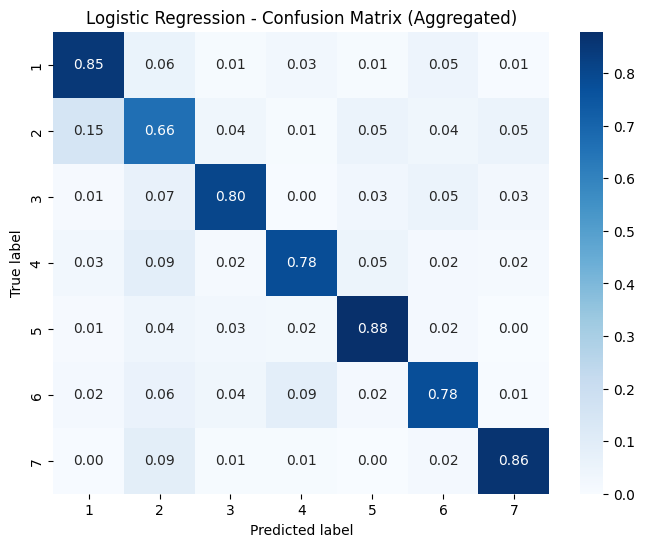

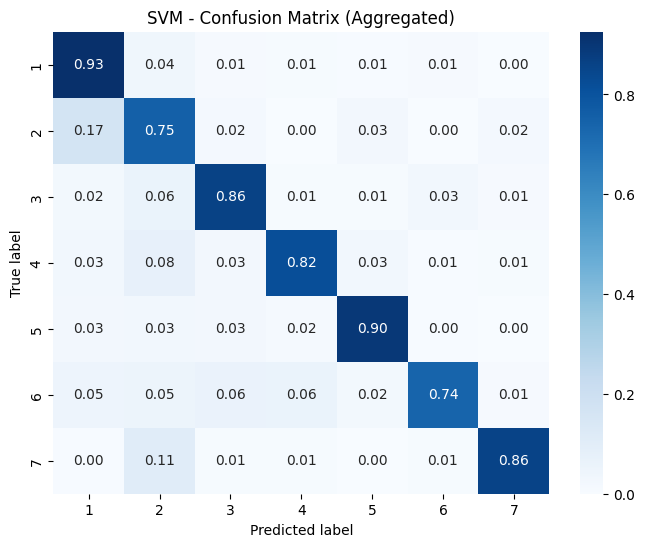

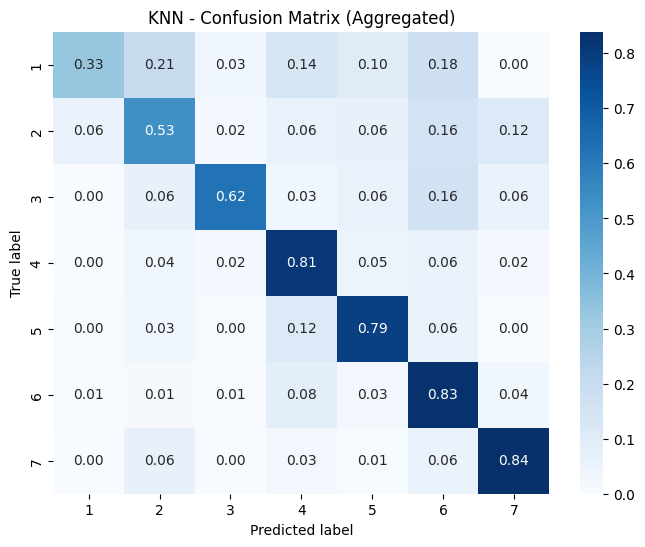

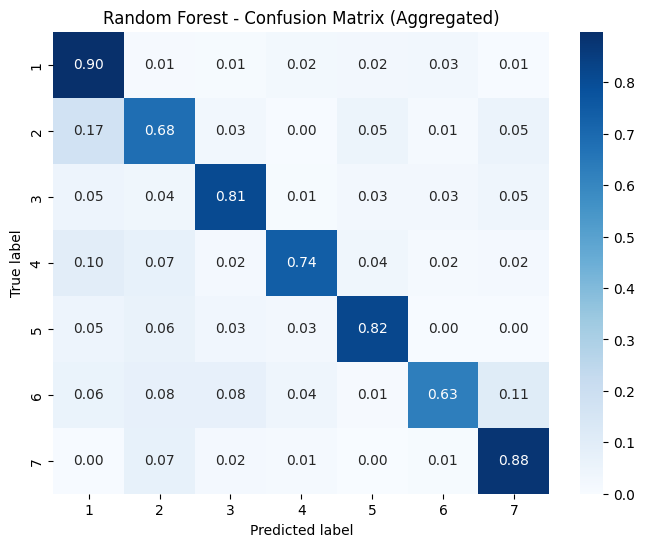

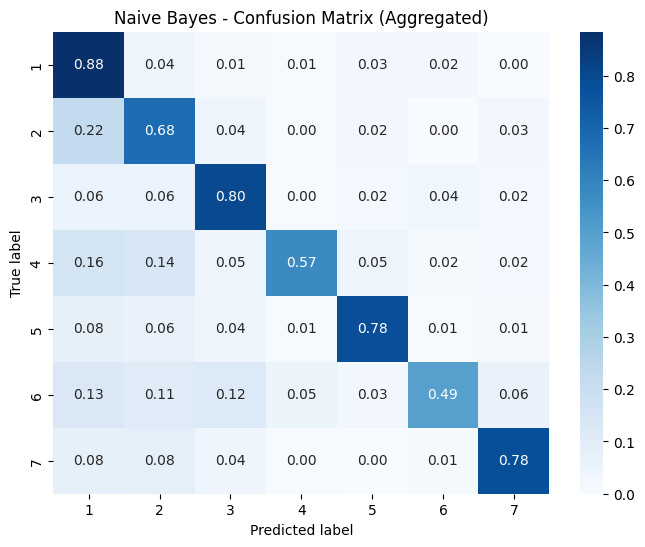

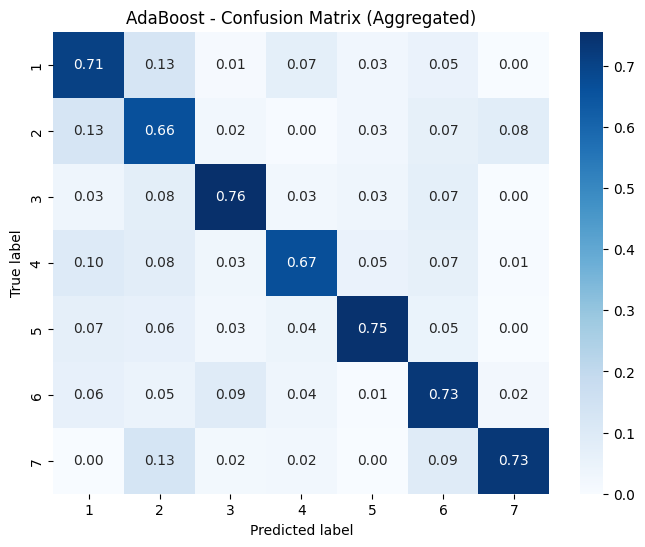

In [ ]:
classes = np.unique(y)
agg_results = aggregate_cv_results(results, classes)

print_summary_metrics(agg_results, classes)
plot_boxplots(results)

for clf_name, metrics in agg_results.items():
    plot_confusion_matrix(metrics['confusion_matrix_sum'], classes, title=f"{clf_name} - Confusion Matrix (Aggregated)")
 